In [6]:
from sklearn.metrics import precision_recall_fscore_support

In [2]:
import torch

# Load embeddings and labels
train_embeddings = torch.load('train_embeddings.pt')
test_embeddings = torch.load('test_embeddings.pt')
val_embeddings = torch.load('val_embeddings.pt')

train_labels = torch.load('train_labels_tensor.pt')
test_labels = torch.load('test_labels_tensor.pt')
val_labels = torch.load('val_labels_tensor.pt')


In [3]:
def normalize_embeddings(embeddings):
    norms = embeddings.norm(p=2, dim=1, keepdim=True)
    normalized_embeddings = embeddings / norms
    return normalized_embeddings

# Normalize the embeddings
train_combined_embeddings_tensor = normalize_embeddings(train_embeddings)
val_combined_embeddings_tensor = normalize_embeddings(val_embeddings)
test_combined_embeddings_tensor = normalize_embeddings(test_embeddings)

# Now the embeddings are normalized and ready for use
print("Train embeddings shape:", train_combined_embeddings_tensor.shape)
print("Validation embeddings shape:", val_combined_embeddings_tensor.shape)
print("Test embeddings shape:", test_combined_embeddings_tensor.shape)

Train embeddings shape: torch.Size([185542, 775])
Validation embeddings shape: torch.Size([23193, 775])
Test embeddings shape: torch.Size([23193, 775])


In [4]:
import torch.nn as nn
import torch.optim as optim

class FFNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.5):
        super(FFNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Example batch norm layer after first dense layer
        self.fc2 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [7]:
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

# Parameters
input_size = train_embeddings.size(1)  # The size of the combined embeddings
hidden_size = 128  # Example hidden layer size
batch_size = 20
epochs = 20
learning_rate = 1e-5

# Create DataLoader
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Instantiate the model
model = FFNClassifier(input_size=input_size, hidden_size=hidden_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate,eps = 1e-8 )
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)  # Adjust step_size and gamma as needed

def compute_accuracy(preds, labels):
    preds = (preds > 0.5).float()  # Convert logits to binary predictions
    correct = (preds.squeeze() == labels).float()
    accuracy = correct.sum() / len(labels)
    return accuracy

def compute_metrics(preds, labels):
    preds = (preds > 0.5).float().cpu().numpy()  # Convert logits to binary predictions
    labels = labels.cpu().numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return precision, recall, f1


# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    #------------------------------------------
    all_preds = []
    all_labels = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute accuracy
        accuracy = compute_accuracy(outputs.squeeze(), labels)
        total_correct += accuracy.item() * len(labels)
        total_samples += len(labels)

        # Collect all predictions and labels
        all_preds.extend(outputs.detach().cpu())
        all_labels.extend(labels.cpu())

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_samples
    scheduler.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

     # Compute precision, recall, and F1 score for the epoch
    precision, recall, f1 = compute_metrics(torch.tensor(all_preds), torch.tensor(all_labels))
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


    
    
    
    
    
# Evaluation
model.eval()
def evaluate(loader):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            predictions = (outputs.squeeze() > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

             # Collect all predictions and labels for metrics computation
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return accuracy, precision, recall, f1

val_accuracy, val_precision, val_recall, val_f1 = evaluate(val_loader)
test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_loader)

print(f'Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}')    

val_accuracy = evaluate(val_loader)
#test_accuracy = evaluate(test_loader)




Epoch 1/20, Loss: 0.5636, Accuracy: 0.8816
Epoch 1/20, Loss: 0.5636, Accuracy: 0.8816, Precision: 0.9193, Recall: 0.8366, F1 Score: 0.8760
Epoch 2/20, Loss: 0.5474, Accuracy: 0.9057
Epoch 2/20, Loss: 0.5474, Accuracy: 0.9057, Precision: 0.9349, Recall: 0.8723, F1 Score: 0.9025
Epoch 3/20, Loss: 0.5451, Accuracy: 0.9096
Epoch 3/20, Loss: 0.5451, Accuracy: 0.9096, Precision: 0.9371, Recall: 0.8783, F1 Score: 0.9068
Epoch 4/20, Loss: 0.5440, Accuracy: 0.9119
Epoch 4/20, Loss: 0.5440, Accuracy: 0.9119, Precision: 0.9383, Recall: 0.8818, F1 Score: 0.9092
Epoch 5/20, Loss: 0.5434, Accuracy: 0.9130
Epoch 5/20, Loss: 0.5434, Accuracy: 0.9130, Precision: 0.9382, Recall: 0.8844, F1 Score: 0.9105
Epoch 6/20, Loss: 0.5429, Accuracy: 0.9138
Epoch 6/20, Loss: 0.5429, Accuracy: 0.9138, Precision: 0.9385, Recall: 0.8856, F1 Score: 0.9113
Epoch 7/20, Loss: 0.5426, Accuracy: 0.9147
Epoch 7/20, Loss: 0.5426, Accuracy: 0.9147, Precision: 0.9390, Recall: 0.8871, F1 Score: 0.9123
Epoch 8/20, Loss: 0.5423, A

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Make predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = (outputs.squeeze() > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(report)


Precision: 0.9440
Recall: 0.8972
F1 Score: 0.9200
Confusion Matrix:
[[10976   617]
 [ 1192 10408]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     11593
           1       0.94      0.90      0.92     11600

    accuracy                           0.92     23193
   macro avg       0.92      0.92      0.92     23193
weighted avg       0.92      0.92      0.92     23193



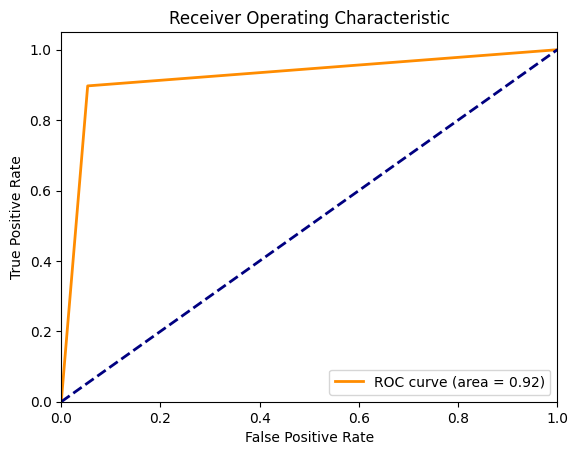

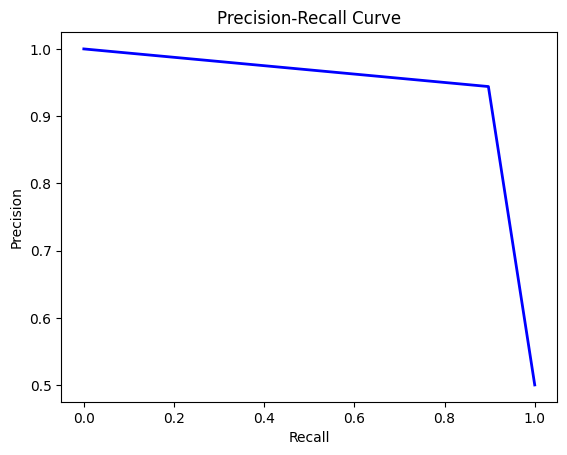

In [9]:
from sklearn.metrics import roc_curve,auc ,precision_recall_curve
from matplotlib import pyplot as plt
# Compute ROC Curve and AUC
fpr, tpr, _ = roc_curve(all_labels, [p for p in all_preds])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Compute Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(all_labels, [p for p in all_preds])
plt.figure()
plt.plot(recalls, precisions, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()